In [1]:
import pandas as pd
import pickle
import json 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from graph_metrics import get_dataframe_from_centralities_dict, plot_centralities
from create_birdnest_input import load_restaurant_data, load_reviewer_data
from evaluation import *

After the algorithms have flagged some of the users in California region as fake reviewers we conclude our finding in the following analysis workbook.

In [2]:
# load the centralities data 
with open('graph_data/reviewer_centralities.pkl', 'rb') as file:
    reviewer_centralities = pickle.load(file)

# keep the information into a pandas dataframe
centralities_df = get_dataframe_from_centralities_dict(reviewer_centralities, 'reviewer')

In [3]:
# load the top rated users by BIRDNEST algorithm 
top_rated_users_df = read_birdnest_results(500, 'ids')

# keep the ids in a list
flagged_users = top_rated_users_df['birdnest_flagged_users'].tolist()

# add a column on centralities dataframe, with the top 200 flagged users by BIRDNEST
centralities_df['flagged_reviewer'] = centralities_df['reviewer'].isin(flagged_users[:200])

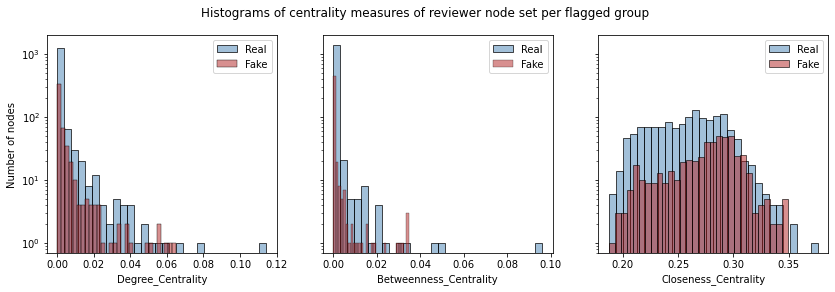

In [4]:
# plot the data
plot_centralities(reviewer_centralities, 'reviewer', split_centralities_on_flag=True, flagged_ids=flagged_users)

The above plots demonstrate centrality distributions in bipartite graphs of real vs fake reviewers.  
The plots are in log-log scale.  

The reviewers that add fake reviews to restaurant demonstrate similar bahavior with real reviewers.  
For example, it would be expected that the hub of the network would be a fake reviewer, however this is not the case.

In [5]:
review_df = load_review_data('data_no_share', 'review.csv')
review_df_subset = review_df[review_df['reviewerID'].isin(centralities_df['reviewer'])]

In [6]:
def plot_review_timeseries(review_df: pd.DataFrame, reviewer_id: str) ->None:

    if reviewer_id not in set(review_df['reviewerID']):
        print(f'Reviewer id {reviewer_id} is not found in the dataset provided')
    else:    
        # get data only regarding that particular user id
        flagged_user_df = review_df[review_df['reviewerID']==reviewer_id][review_df['date'].apply(lambda x: 'Update' not in x)]
        flagged_user_df['flagged'] = flagged_user_df['flagged'].apply(lambda x: 'Real' if x in ['N', 'NR'] else 'Fake')
        flagged_user_df['date'] = pd.to_datetime(flagged_user_df['date'])

        # get the timeseries of reviews and counts per fake/ real review
        review_dates_df = flagged_user_df.groupby(['date', 'flagged'])['reviewID'].count().reset_index().rename(columns={'reviewID': 'review_counts'}).sort_values(by='date').reset_index(drop=True)
        
        #get the rating of the reviewer
        summed_ratings_df = flagged_user_df.groupby(['date', 'flagged'])['rating'].sum().reset_index().rename(columns={'rating': 'summed_rating'}).sort_values(by='date').reset_index(drop=True)

        # merge the information into the same dataframe and keep the avg rating
        stats_df = review_dates_df.merge(summed_ratings_df, how='inner')
        stats_df['avg_rating'] = stats_df['summed_rating']/stats_df['review_counts']

        plt.figure(figsize=(20, 4))

        # timeseries plot 
        plt.subplot(1,3,(1,2))
        plt.title(f'Timeseries of reviews of reviewer {reviewer_id}')
        sns.lineplot(x='date', y='review_counts', hue='flagged', hue_order=['Fake', 'Real'], 
                     data=stats_df, palette='rocket', alpha=0.7, sizes=4)
        plt.ylabel('Number of reviews posted')

        # rating distribution 
        plt.subplot(1,3,3)
        plt.title('Rating distribution or reviewer')
        # sns.kdeplot(x='avg_rating', hue='flagged', data=stats_df, 
        #         palette = 'rocket', fill=True, alpha=0.2, bw_adjust=1)
        # plt.xlabel('Average restaurant rating in stars [1-5]')
        sns.countplot(x = stats_df['avg_rating'].astype(int), hue='flagged', hue_order=['Fake', 'Real'], 
                      data = stats_df, palette='rocket', fill=True, alpha=0.8)
        plt.xlabel('Restaurant rating in stars [1-5]')

        plt.tight_layout()
        plt.show()


The following user (ranked with the 3rd highest score by BIRDNEST) reviewed **more than 300 restaurants in a single day**.  
This behavior is very unnatural and resembles **bot-like behavior**.

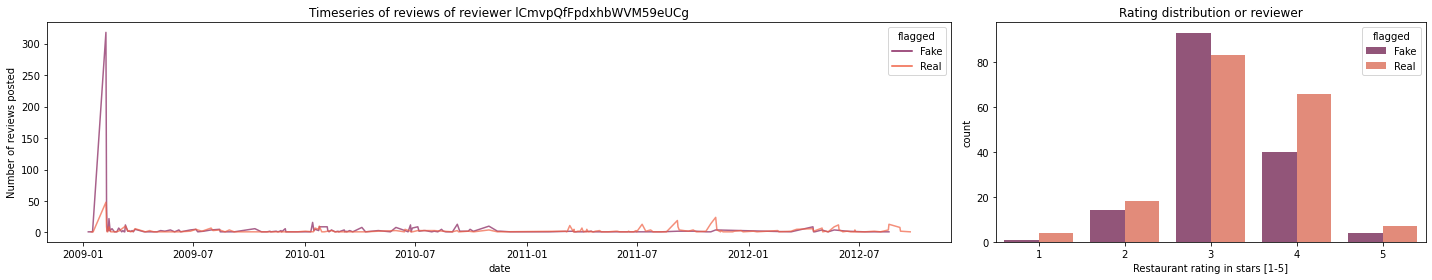

In [7]:
plot_review_timeseries(review_df_subset, flagged_users[2])

Another user seems to be writting many honest reviews the same date he is writing fake reviews to **camouflage** his fraudulent actions.

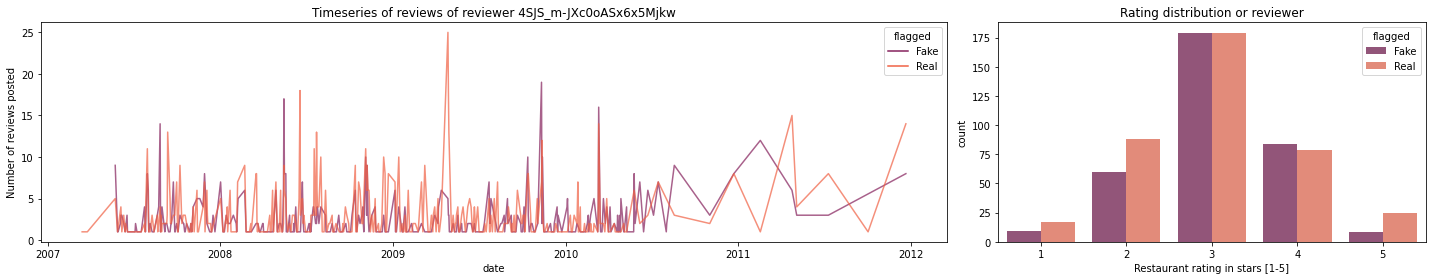

In [8]:
plot_review_timeseries(review_df_subset, flagged_users[4])

This one, does not write reviews often, but always writes then in bulk. Most of his/her reviews are also considered fake.

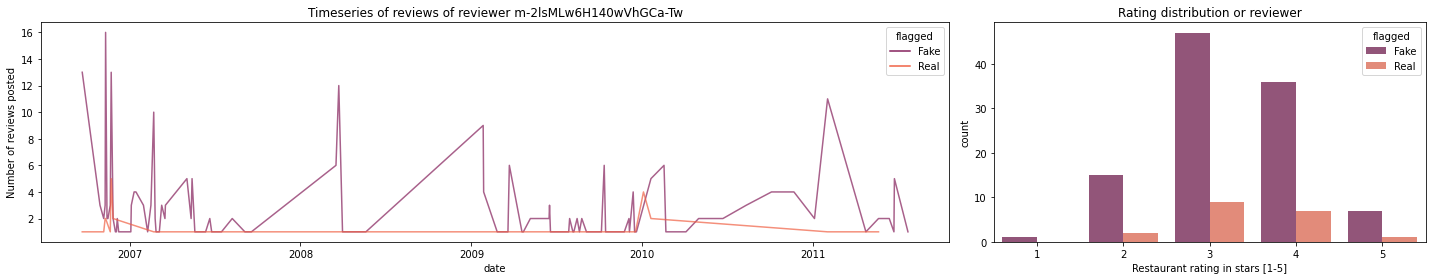

In [9]:
plot_review_timeseries(review_df_subset, flagged_users[7])

Reviewers are considered as fraud if at least 1.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 10.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 20.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 30.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 50.00% of their reviews is flagged as fake


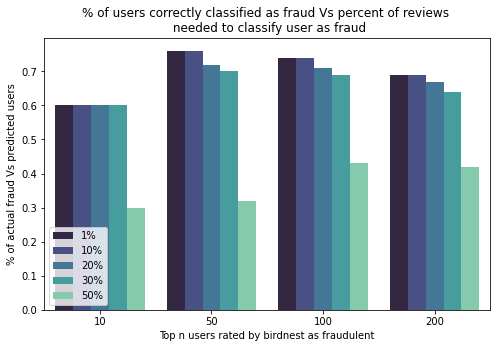

In [10]:
# pivot the review subset data
pivoted_df = flagged_data_pivot(review_df_subset, 'reviewer')

# get the results
results_df = df = get_results_accuracy(pivoted_df, top_rated_users_df, [0.01, 0.1, 0.2, 0.3, 0.5], [10,50,100,200],True,False)

In [11]:
# load restaurant data
restaurant_df = load_restaurant_data('data_no_share/yelpResData')
# keep information about restaurant in CA state
restaurants_CA = restaurant_df[restaurant_df['restaurant_state']=='CA'].reset_index(drop=True)

# merge the information with the reviews 
restaurant_review_subset = review_df_subset.merge(restaurants_CA, on='restaurantID', how='inner')
restaurant_review_subset['flagged'] = restaurant_review_subset['flagged'].apply(lambda flag: 'Fake' if flag in ('Y', 'YR') else 'Real')

Can we infer some information from the review characteristics?  
Such as how many users found the review useful etc.

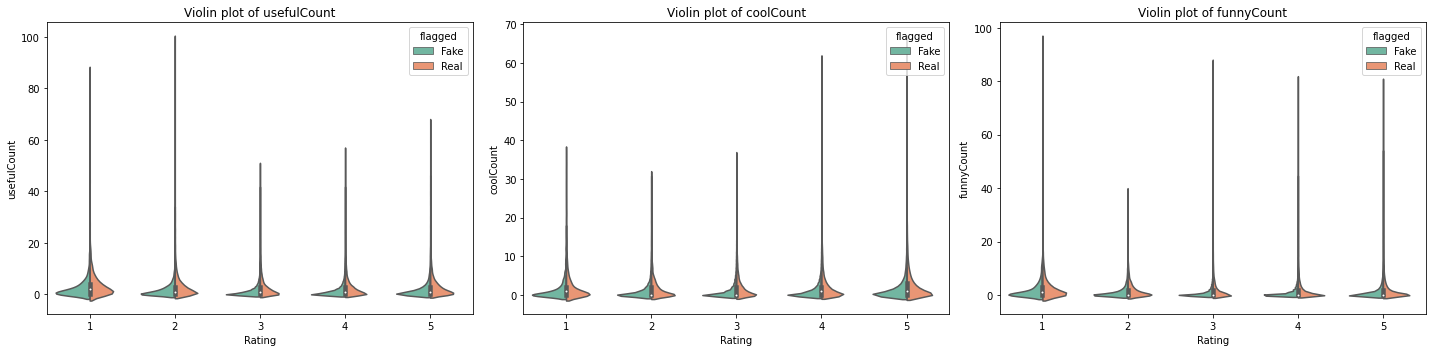

In [12]:
# plot violin plots of various review characteristics
plt.figure(figsize=(20, 5))
for n, var in zip(range(1,4), ['usefulCount', 'coolCount', 'funnyCount']):
    plt.subplot(1,3,n)
    plt.title(f'Violin plot of {var}')
    sns.violinplot(y=var, x='rating', hue='flagged', data=restaurant_review_subset, 
                   split=True, palette='Set2', alpha=0.5)
    plt.xlabel('Rating')
    plt.ylabel(var)
plt.tight_layout()

(-5.0, 15.0)

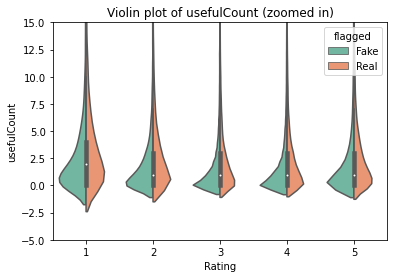

In [13]:
plt.title('Violin plot of usefulCount (zoomed in)')
sns.violinplot(y='usefulCount', x='rating', hue='flagged', data=restaurant_review_subset, 
                   split=True, palette='Set2', alpha=0.5)
plt.xlabel('Rating')
plt.ylim(-5, 15)

In [14]:
# also get a dataframe of results
restaurant_review_subset.groupby('flagged')[['usefulCount', 'coolCount', 'funnyCount']].agg(['min', 'max', 'median','mean', 'std'])

usefulCount                                coolCount             \
                min max median      mean       std       min max median   
flagged                                                                   
Fake              0  67      1  1.894335  3.233045         0  66      0   
Real              0  99      2  2.822582  3.811928         0  61      1   

                           funnyCount                                 
             mean      std        min max median      mean       std  
flagged                                                               
Fake     1.542673  2.93010          0  80      0  1.265267  2.740530  
Real     2.186177  3.37386          0  95      1  1.835871  3.430724

In [15]:
restaurant_review_subset['flagged'] = restaurant_review_subset['flagged'].apply(lambda x: 'Y' if x=='Fake' else 'N')
restaurant_pivot = flagged_data_pivot(df=restaurant_review_subset, mode='restaurant')
restaurant_pivot['total_reviews'] = restaurant_pivot['N'] + restaurant_pivot['Y']

Text(0.5, 0, 'Reviews percent')

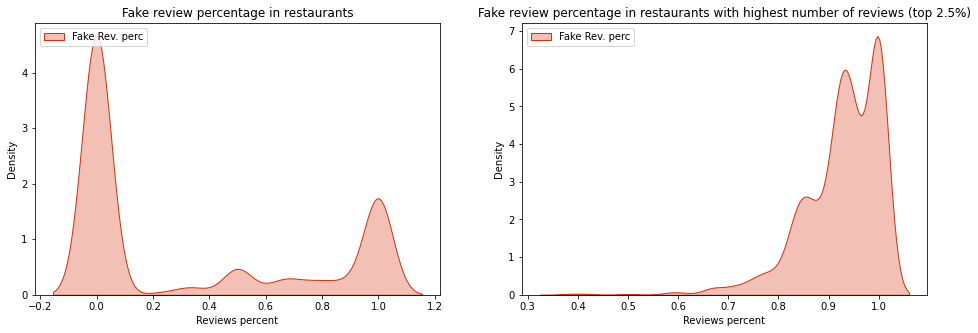

In [16]:
plt.figure(figsize=(16,5))

# plot percentage of fraud/ honest reviews per restaurant
plt.subplot(1,2,1)
plt.title('Fake review percentage in restaurants')
#sns.kdeplot(x='N_review_percent', data=restaurant_pivot, color='#0CB6D6', fill=True, alpha=0.3, label='Real Rev. perc')
sns.kdeplot(x='Y_review_percent', data=restaurant_pivot, color='#D62F0C', fill=True, alpha=0.3, label='Fake Rev. perc')
plt.legend(loc='upper left')
plt.xlabel('Reviews percent')

# plot the same plot, but only for restaurants with many reviews 
plt.subplot(1,2,2)
plt.title('Fake review percentage in restaurants with highest number of reviews (top 2.5%)')
# sns.kdeplot(x='N_review_percent', color='#0CB6D6', fill=True, alpha=0.3, label='Real Rev. perc',
#             data=restaurant_pivot[restaurant_pivot['total_reviews'] > np.quantile(restaurant_pivot['total_reviews'], 0.975)])
sns.kdeplot(x='Y_review_percent', color='#D62F0C', fill=True, alpha=0.3, label='Fake Rev. perc',
            data=restaurant_pivot[restaurant_pivot['total_reviews'] > np.quantile(restaurant_pivot['total_reviews'], 0.975)])
plt.legend(loc='upper left')
plt.xlabel('Reviews percent')

In the plot above we can observe that restaurants can have either no fake reviews or all their reviews are fake!  
There is only a small amount of restaurants that share both fake and honest reviews (approximatelly in 50-50 percent of reviews)  
However, when taking a look on the restaurants with the highest number of reviews (top 2.5%), we see that almost all of the reviews posted on Yelp are fake!

<AxesSubplot:xlabel='rating', ylabel='Density'>

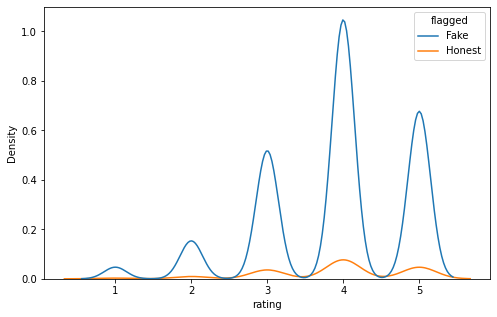

In [17]:
# get a list of the restaurant ids with the highest number of reviews 
many_reviews_restaurants = restaurant_pivot[restaurant_pivot['total_reviews'] > np.quantile(restaurant_pivot['total_reviews'], 0.975)].reset_index()['restaurantID']

many_reviews_restaurants_df = restaurant_review_subset[restaurant_review_subset['restaurantID'].isin(many_reviews_restaurants)]
many_reviews_restaurants_df['flagged'] = many_reviews_restaurants_df['flagged'].apply(lambda x: 'Fake' if x=='Y' else 'Honest')
# keep count of the reviews per real/ fake review
review_counts_df = many_reviews_restaurants_df.groupby(['restaurantID', 'flagged'])['flagged'].count().rename('review_count').reset_index()
many_reviews_restaurants_df = many_reviews_restaurants_df[many_reviews_restaurants_df['restaurantID'].isin(review_counts_df['restaurantID'].value_counts()[review_counts_df['restaurantID'].value_counts()==2].index)]

# plot the data 
plt.figure(figsize=(8, 5))
sns.kdeplot(x='rating', hue='flagged', data=many_reviews_restaurants_df)

In [18]:
df = restaurant_pivot.merge(
    restaurant_review_subset[['restaurantID', 'restaurant_PriceRange', 'restaurant_Attire']], on='restaurantID', how='left')
df.loc[df['restaurant_PriceRange'].isnull(), 'restaurant_PriceRange'] = 'Not Specified'

price_mapper = {'Not Specified': 'Not Specified',
                '$': 'Inexpensive', 
                '$$': 'Moderately expensive',
                '$$$': 'Expensive',
                '$$$$': 'Very Expensive'}
df['restaurant_PriceRange'].replace(price_mapper, inplace=True)

df.loc[df['restaurant_Attire'].isnull(), 'restaurant_Attire'] = 'Not Specified'

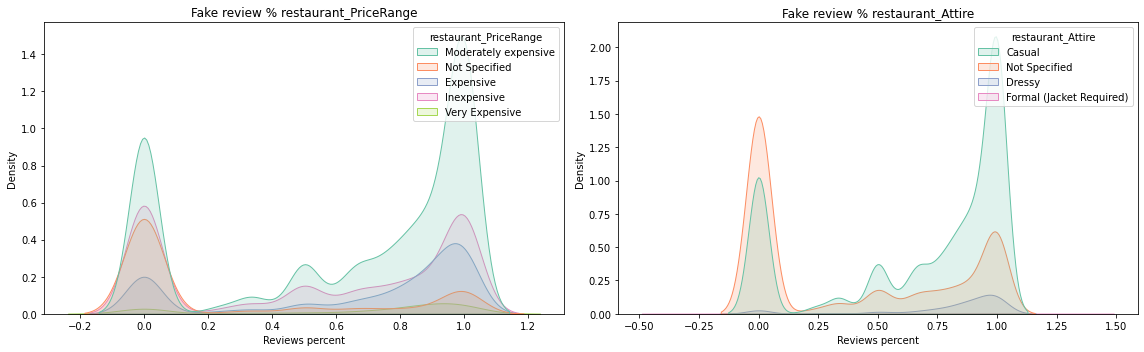

In [19]:
plt.figure(figsize=(16,5))

for n, grouping_val in enumerate(['restaurant_PriceRange', 'restaurant_Attire']):
    plt.subplot(1,2,n+1)
    plt.title(f'Fake review % {grouping_val}')
    sns.kdeplot(x='Y_review_percent', hue=grouping_val, data=df, 
                palette='Set2', fill=True, alpha=0.2)
    plt.xlabel('Reviews percent')
plt.tight_layout()

In [20]:
# load restaurant communities from spectral clustering
with open('spectral_clustering_5_results.txt', 'r') as f:
    doc=f.readlines()

restorant_communities = json.loads(doc[1].split('===')[0])

In [21]:
ca_restaurant_df =  restaurant_df[restaurant_df['restaurant_state']=='CA']
ca_restaurant_df['restaurant_city'] = ca_restaurant_df['restaurant_location'].apply(lambda location: location.split(' -')[-1].split(',')[0].strip())

ca_restaurant_df['cluster'] = np.nan

for clust in restorant_communities.keys():
    ca_restaurant_df.loc[ca_restaurant_df['restaurantID'].isin(restorant_communities[clust]), 'cluster'] = clust

In [22]:
res_counts = ca_restaurant_df.groupby('restaurant_city')['restaurantID'].count().reset_index().rename(columns={'restaurantID':'n_restaurants'})

In [23]:
# !pip install folium 
# !pip install geopy
# !pip install Nominatim
import folium 
from geopy.geocoders import Nominatim

In [24]:
# is the username stolen? probably yes 
# https://www.programcreek.com/python/example/108180/geopy.geocoders.Nominatim
# nom = Nominatim(user_agent="catuserbot")

# res_counts['latitude'] = res_counts['restaurant_city'].apply(lambda loc: nom.geocode(f'{loc}, CA').latitude)
# res_counts['longitude'] = res_counts['restaurant_city'].apply(lambda loc: nom.geocode(f'{loc}, CA').longitude)
ca_geolocations = pd.read_csv('data_no_share/ca_geo.csv')
res_counts = res_counts.merge(ca_geolocations, on='restaurant_city', how='inner')

In [25]:
color_palette = sns.color_palette('viridis', n_colors=res_counts['n_restaurants'].max())

In [26]:
res_counts = res_counts[~res_counts['longitude'].isnull()]

In [27]:
ca_map = folium.Map(location=[36.7783, -119.4179], zoom_start=7, tiles="OpenStreetMap")

for lat, lon, res_count, city in zip(res_counts['latitude'], res_counts['longitude'], res_counts['n_restaurants'], res_counts['restaurant_city']):
    folium.CircleMarker(
        [lat, lon],
        #radius=.02*res_count,
        radius=np.log(res_count)+0.5,
        popup = ('City: ' + str(city).capitalize() + '<br>'
                 'Restaurant count: ' + str(res_count) + '<br>'
                ),
        color='b',
        icon=folium.Icon(icon_color=color_palette.as_hex()[res_count-1]),
        #key_on = traffic_q,
        #threshold_scale=[0,1,2,3],
        fill_color=color_palette.as_hex()[res_count-1],
        fill=True,
        fill_opacity=0.9
        ).add_to(ca_map)
ca_map

Are the clusters produced by spectral clustering representative of a "geo clustering"?  
Practically, did spectral clustering used on the projected restaurant graph group together restaurants that are in close locations? (We expect such restaurants to have more common reviewers)

In [28]:
X = res_counts[['latitude', 'longitude']].to_numpy()
# using 3 clusters, because 2 clusters classify all items into one cluster
cl = KMeans(n_clusters=5, random_state=313).fit(X)
res_counts['geo_cluster'] = cl.labels_

In [29]:
color_palette = {0:'orange', 1:'navyblue', 2:'black', 3:'red', 4:'green', 5:'purple'}

ca_map = folium.Map(location=[36.7783, -119.4179], zoom_start=5, tiles="OpenStreetMap")

for lat, lon, res_count, city, geo_cluster in zip(res_counts['latitude'], res_counts['longitude'], res_counts['n_restaurants'], res_counts['restaurant_city'], res_counts['geo_cluster']):
    folium.CircleMarker(
        [lat, lon],
        #radius=.02*res_count,
        radius=np.log(res_count)+0.5,
        popup = ('City: ' + str(city).capitalize() + '<br>'
                 'Restaurant count: ' + str(res_count) + '<br>'
                ),
        color='b',
        icon=folium.Icon(icon_color=color_palette[int(geo_cluster)]),
        #key_on = traffic_q,
        #threshold_scale=[0,1,2,3],
        fill_color=color_palette[geo_cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(ca_map)
ca_map

In [30]:
# merge the information on the californian restaurants
ca_restaurant_df = ca_restaurant_df.merge(res_counts[['restaurant_city', 'geo_cluster']], on='restaurant_city', how='inner')

Text(0.5, 1.0, 'Spectral clustering of restaurant projection vs geographical clustering of restaurants')

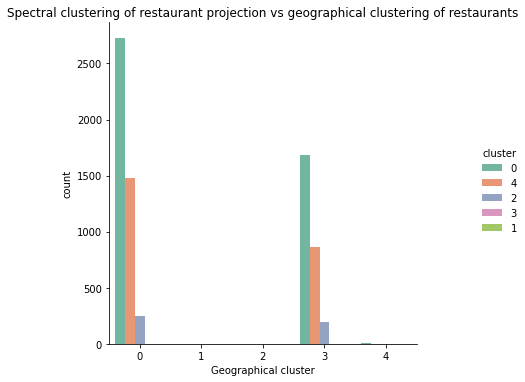

In [31]:
# # overwrite clusters because there are wrong entries in the data (restaurants in Quebeq, Edmonton etc.)
#ca_restaurant_df[ca_restaurant_df['geo_cluster']==2]['geo_cluster']=1

sns.catplot(x='geo_cluster', kind='count', hue='cluster', data=ca_restaurant_df, palette='Set2')
plt.xlabel('Geographical cluster')
plt.title('Spectral clustering of restaurant projection vs geographical clustering of restaurants')

In [32]:
reviewer_df = load_reviewer_data('data_no_share/yelpResData')
# keep only the reviewers that have reviewed CA restaurants
reviewer_df = reviewer_df[reviewer_df['reviewerID'].isin(reviewer_centralities['Degree_Centrality'].keys())]

reviewer_with_percents_df = reviewer_df.merge(pivoted_df, on='reviewerID', how='left')

Text(0.5, 0, 'Fake reviews %')

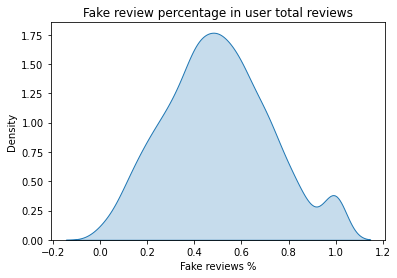

In [33]:
sns.kdeplot(x='Y_review_percent', fill=True, palette='ocean', data=reviewer_with_percents_df)
plt.title('Fake review percentage in user total reviews')
plt.xlabel('Fake reviews %')

In [34]:
reviewer_with_percents_df['total_reviews_written'] = reviewer_with_percents_df['N'] + reviewer_with_percents_df['Y']

Text(0.5, 1.0, 'Total reviews in different user groups')

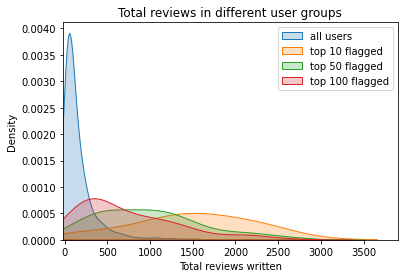

In [35]:
sns.kdeplot(x='total_reviews_written', data=reviewer_with_percents_df, label='all users', fill=True, palette='gnuplot')
sns.kdeplot(x='total_reviews_written', label='top 10 flagged', palette='gnuplot', fill=True, 
    data=reviewer_with_percents_df[reviewer_with_percents_df['reviewerID'].isin(top_rated_users_df.iloc[:10]['birdnest_flagged_users'])])
sns.kdeplot(x='total_reviews_written', label='top 50 flagged', palette='gnuplot', fill=True, 
    data=reviewer_with_percents_df[reviewer_with_percents_df['reviewerID'].isin(top_rated_users_df.iloc[:50]['birdnest_flagged_users'])])
sns.kdeplot(x='total_reviews_written', label='top 100 flagged', palette='gnuplot', fill=True, 
    data=reviewer_with_percents_df[reviewer_with_percents_df['reviewerID'].isin(top_rated_users_df.iloc[:100]['birdnest_flagged_users'])])
plt.legend(loc='upper right')
plt.xlim(-20)
plt.xlabel('Total reviews written')
plt.title('Total reviews in different user groups')

#### SpEagle Results

In [36]:
with open('data/speagle_output/speagle_user_ids_CA.pkl', 'rb') as f:
    speagle_results = pickle.load(f)

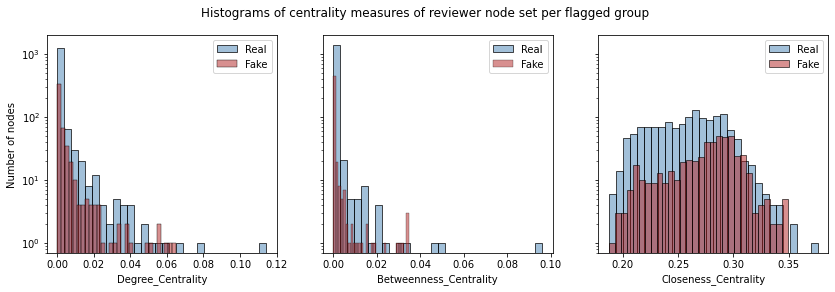

In [37]:
# Again, for the centralitites add a column that indicates flagged users by SpEagle
centralities_df['flagged_reviewer'] = centralities_df['reviewer'].isin(speagle_results[:200])
plot_centralities(reviewer_centralities, 'reviewer', split_centralities_on_flag=True, flagged_ids=flagged_users)

Reviewer id 6zFRjP-zoS8Caozwn4fHMA is not found in the dataset provided
Reviewer id RzORKQ57vpDTBVRTXWDGmQ is not found in the dataset provided


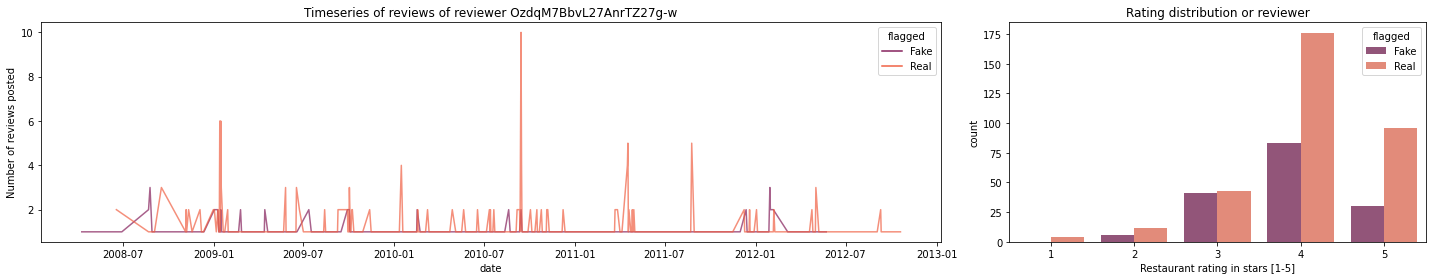

Reviewer id SzHQYCPxQhH9YkbWdG6gGg is not found in the dataset provided


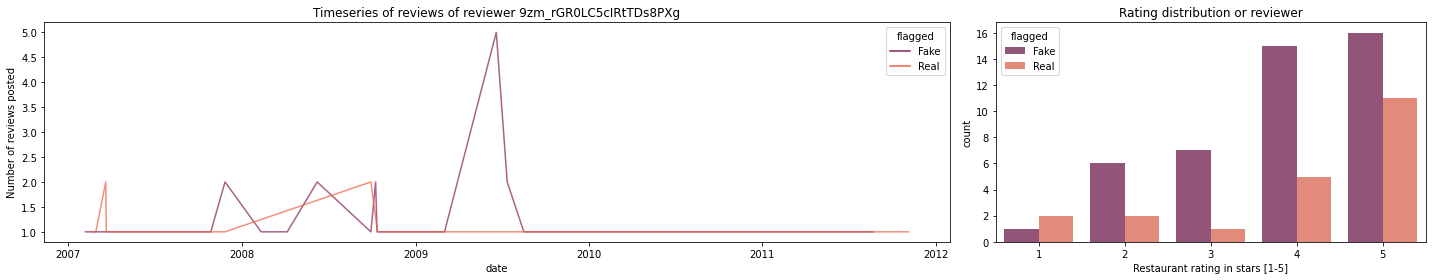

Reviewer id hzmTQMkTGTUQ-aRdKAcUzA is not found in the dataset provided
Reviewer id nzdDOKtOAdHChtpdxyV6_w is not found in the dataset provided
Reviewer id IzXKQx7G4Fy6QCrXMicnmg is not found in the dataset provided


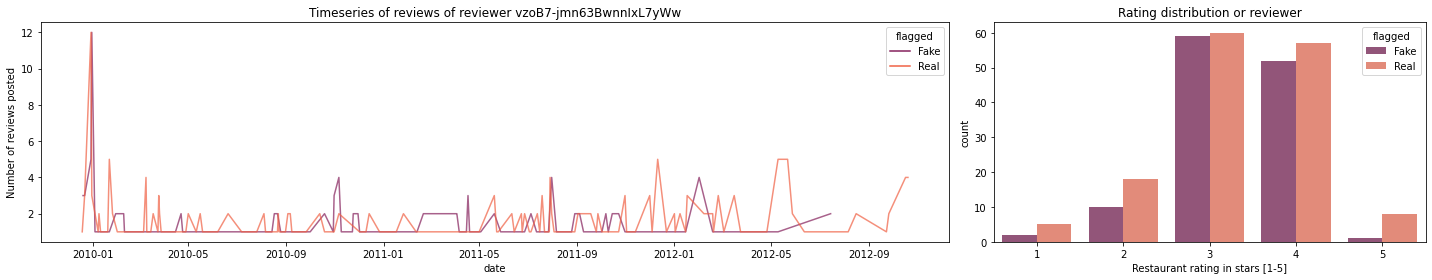

Reviewer id tzIXMXadrzQ4i7TGgIroOw is not found in the dataset provided
Reviewer id pze5vYe1L9z0Lt9EGDALFw is not found in the dataset provided


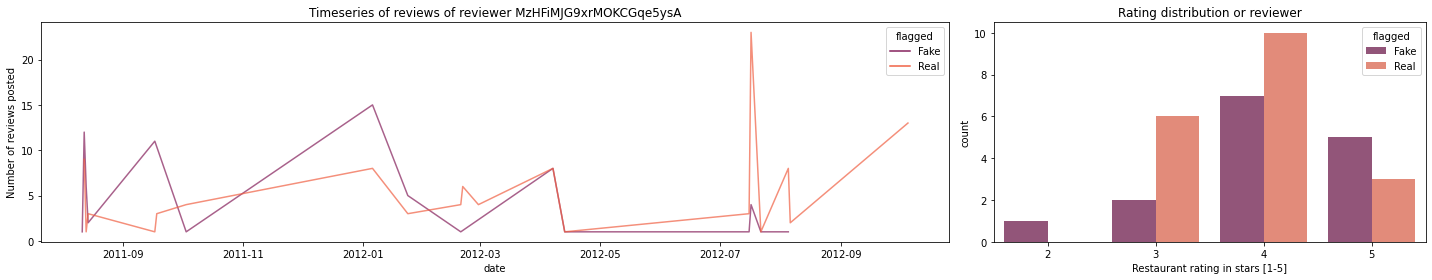

Reviewer id 9zG2PRZnMGe5F29a5NK6Rw is not found in the dataset provided
Reviewer id Uzjz5_qpi9rwlmFhRU9HYg is not found in the dataset provided
Reviewer id BzNIe31xU3Zpvs1mMLBMLw is not found in the dataset provided
Reviewer id JzFpaK_20FOQfK4hYdlC3g is not found in the dataset provided


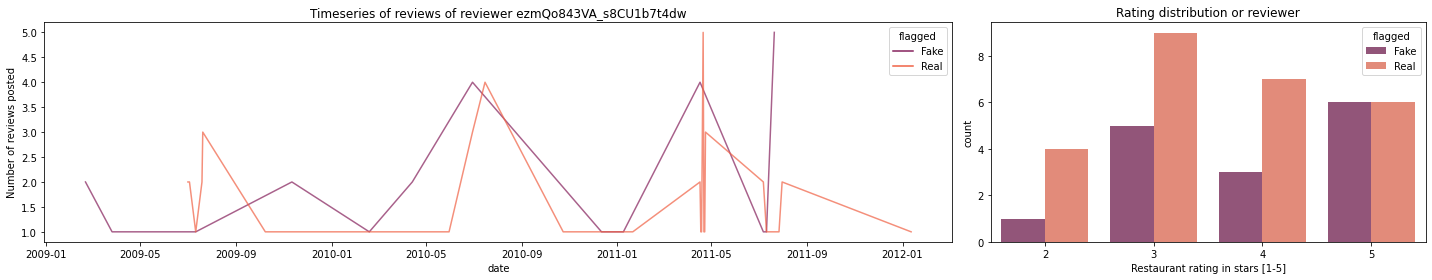

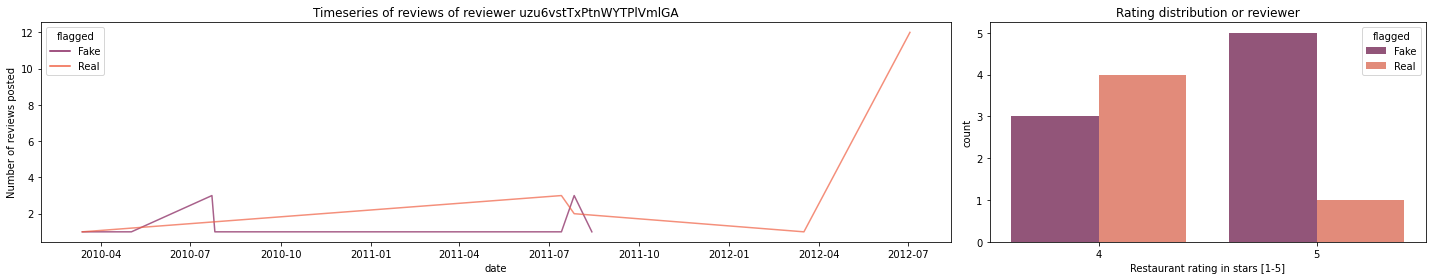

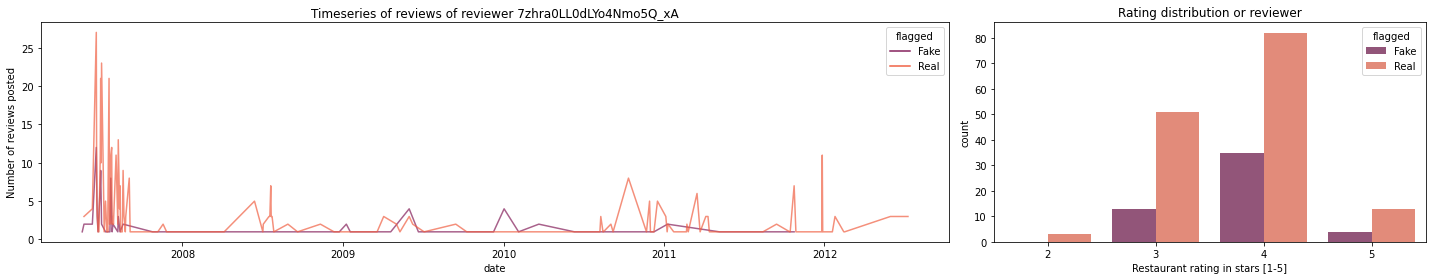

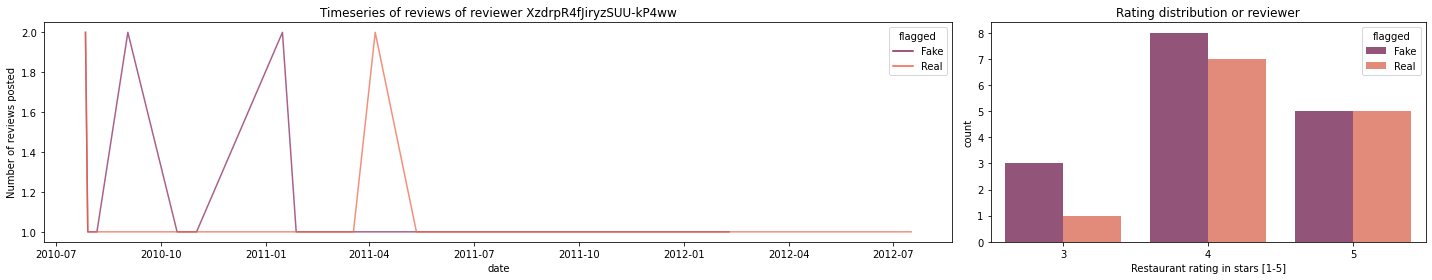

Reviewer id mzXDuhZBPdHfMIk1YXP0mQ is not found in the dataset provided
Reviewer id 0zCHotSr5wr78XzxHczA-g is not found in the dataset provided
Reviewer id nzgqccQQN2Yv-w1GFeFRPA is not found in the dataset provided
Reviewer id DzPFU5i8dbX-wBC6n6cz6A is not found in the dataset provided


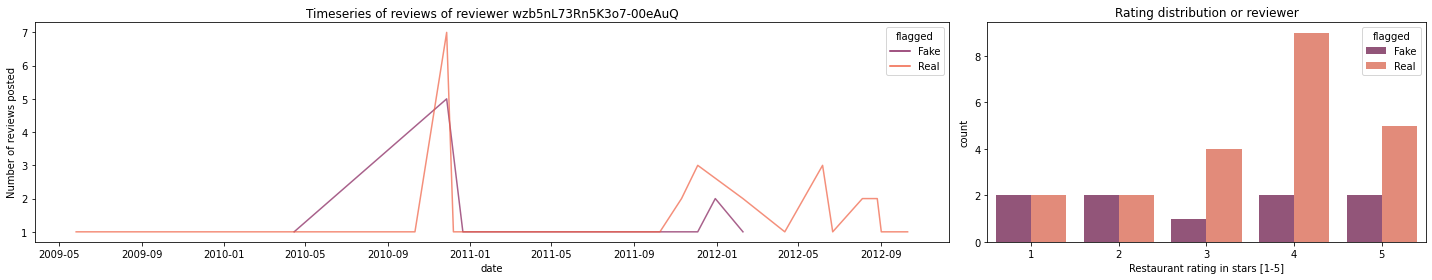

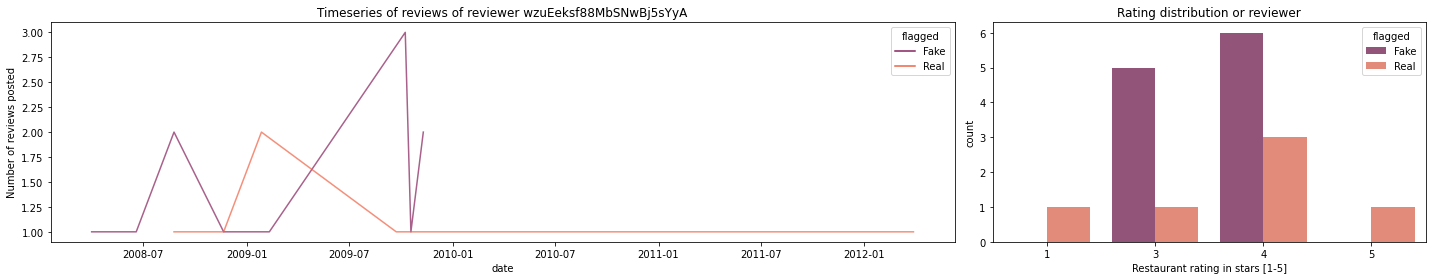

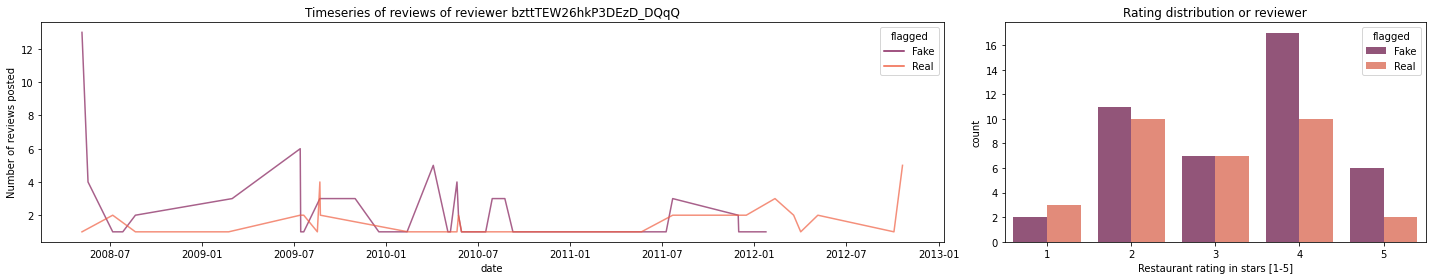

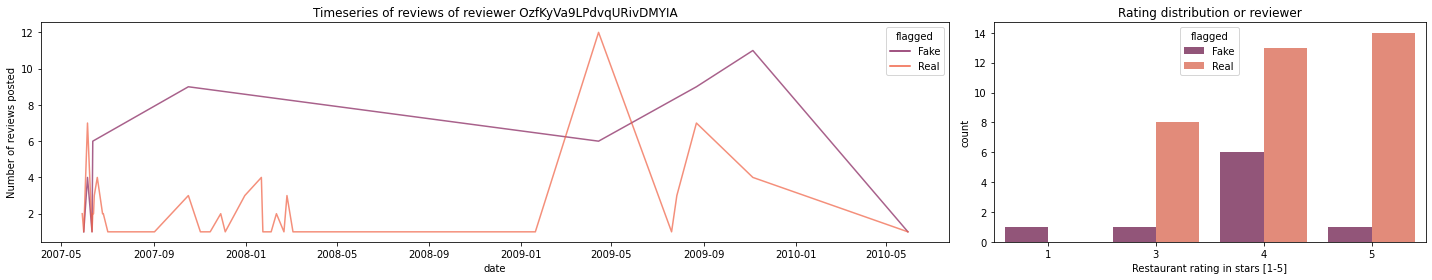

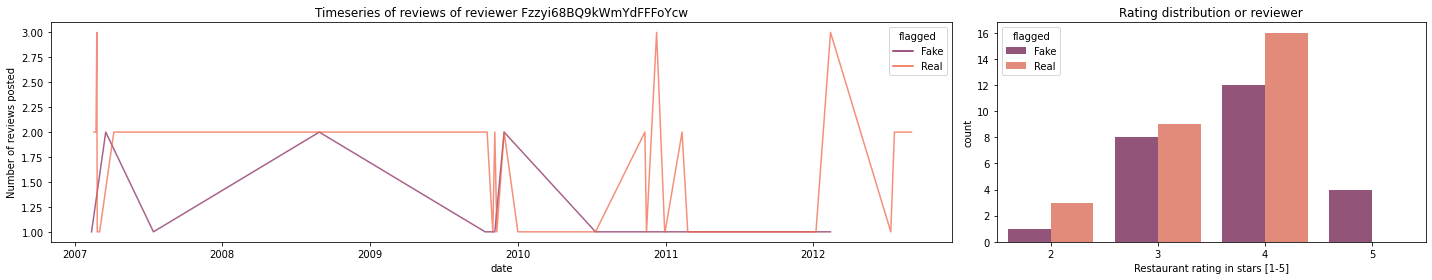

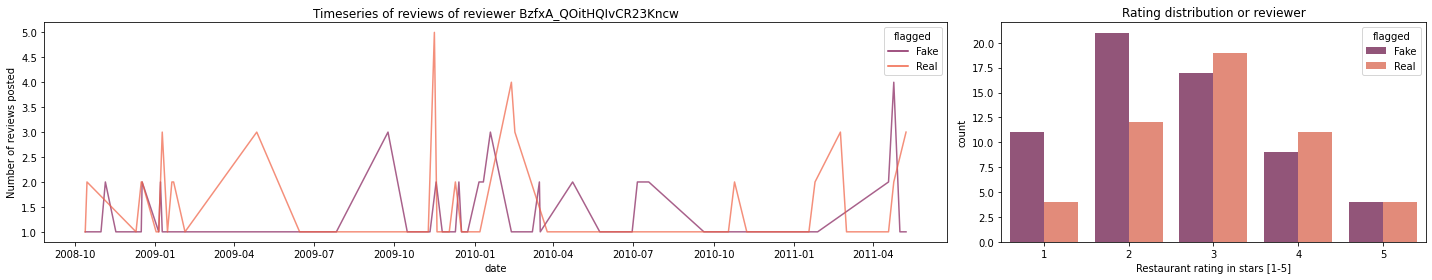

In [38]:
# plot results for individual users
for n in range(30):
    plot_review_timeseries(review_df_subset, speagle_results[n])

Reviewers are considered as fraud if at least 1.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 10.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 20.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 30.00% of their reviews is flagged as fake
Reviewers are considered as fraud if at least 50.00% of their reviews is flagged as fake


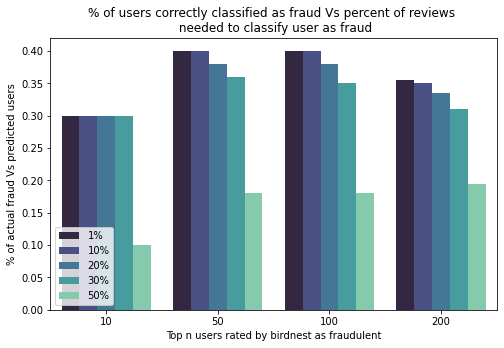

In [37]:
# top_rated_users_df=birdnest results
# get the results
results_df = df = get_results_accuracy(pivoted_df, pd.DataFrame(speagle_results), [0.01, 0.1, 0.2, 0.3, 0.5], [10,50,100,200],True,False)